In [1]:
from mitosplit_net import util, plotting, evaluation, preprocessing

import numpy as np
import pandas as pd
from skimage.color import label2rgb
from skimage import filters, measure, segmentation

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', labelsize=20)
plt.rc('legend', fontsize=18)

from tqdm import tqdm
import tensorflow as tf

In [2]:
#Define GPU device where the code will run on
gpu = tf.config.list_physical_devices('GPU')[0]
print(gpu)
tf.config.experimental.set_memory_growth(gpu, True)
gpu = tf.device('GPU:0/')

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
base_dir = r'C:\Users\roumba\Documents\Software\deep-events'
data_path = base_dir+ r'\Norm_data'  
model_path = base_dir

In [5]:
## INPUT DATA ##

input_data = util.load_h5(data_path, '\data_aug')
output_data = util.load_h5(data_path, '\data_gauss_aug')

input_test = util.load_h5(data_path,'\data_val')
output_test = util.load_h5(data_path,'\data_gauss_val')


# as_type=dict ??


Loading C:\Users\roumba\Documents\Software\deep-events\Norm_data\data_aug.h5
Converting to array

Loading C:\Users\roumba\Documents\Software\deep-events\Norm_data\data_gauss_aug.h5
Converting to array

Loading C:\Users\roumba\Documents\Software\deep-events\Norm_data\data_val.h5
Converting to array

Loading C:\Users\roumba\Documents\Software\deep-events\Norm_data\data_gauss_val.h5
Converting to array


In [8]:
folder_name = util.get_filename(model_path, 'ref_f8')
idx_sort = np.argsort([int(model_name.split('_b')[-1]) for model_name in folder_name])
folder_name = [folder_name[i] for i in idx_sort]
nb_models = len(folder_name)


model = util.load_model(model_path, ['model']*nb_models, folder_name, as_type=dict)
history = util.load_pkl(model_path, ['history']*nb_models, folder_name, as_type=dict)


Done.
Done.


In [10]:
pred_output_test = {}

model_pbar = tqdm(model.keys())
for model_name in model_pbar:
  model_pbar.set_description("Processing %s" %model_name)
  pred_output_test[model_name] = evaluation.predict(input_test[model_name], model[model_name])

## WHAT??????????????????????? ##

0it [00:00, ?it/s]


In [11]:
pred_threshold = np.array([0.1, 0.2, 0.3, 0.5])
f1_score = {}
optimal_pred_threshold = {}
pred_labels_test = {}

for model_name in model:
  print("Processing %s" %model_name)
  f1_score[model_name] = evaluation.get_f1_curve(labels_test[model_name], pred_output_test[model_name], pred_threshold)
  
  optimal_pred_threshold[model_name] = evaluation.get_optimal_threshold(pred_threshold, f1_score[model_name])
  
  pred_labels_test[model_name] = evaluation.label(pred_output_test[model_name], threshold=optimal_pred_threshold[model_name])
  print('\n')
  
util.save_pkl(pred_threshold, model_path, 'ref_pred_threshold')
util.save_pkl(f1_score, model_path, 'ref_f1_score')
util.save_pkl(optimal_pred_threshold, model_path, 'ref_optimal_pred_threshold')


Saving C:\Users\roumba\Documents\Software\deep-eventsref_pred_threshold
Done.

Saving C:\Users\roumba\Documents\Software\deep-eventsref_f1_score
Done.

Saving C:\Users\roumba\Documents\Software\deep-eventsref_optimal_pred_threshold
Done.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


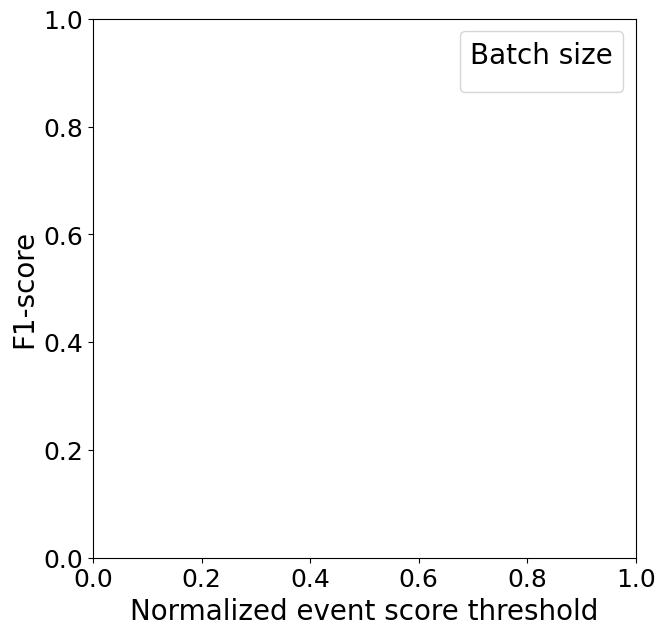

In [12]:
batch_size = [int(model_name.split('_b')[-1]) for model_name in folder_name]

num_models = len(batch_size)
cbar_ticks = np.arange(num_models)

norm_bounds = -1, num_models-1
norm = Normalize(*norm_bounds)
cmap = plt.cm.ScalarMappable(cmap='Oranges', norm=norm)
colors = cmap.get_cmap()(norm(cbar_ticks))

fig, ax = plt.subplots(figsize=(7, 7))
for model_name, b, c in zip(model, batch_size, colors):
  ax.plot(pred_threshold, f1_score[model_name], 'o-', color=c, label=b)

ax.set(xlabel='Normalized event score threshold', ylabel='F1-score', ylim=(0, 1))
ax.legend(title='Batch size', title_fontsize=20)
plt.show()

In [ ]:
title = 'ref_examples'
filename = base_dir+'Figures/'+title+'.pdf'
print(filename)

title_size = 36

fig, axes = plt.subplots(2, nb_models, figsize=(4*nb_models, 8))
fig.suptitle('Batch size', size=title_size)
for model_name, b, i in zip(folder_name, [8, 16, 32, 256], range(nb_models)):
  frame = np.random.choice(np.where(np.any(np.any(output_test[model_name]>0, axis=-1), axis=-1))[0])
  mask = pred_output_test[model_name][frame]>optimal_pred_threshold[model_name]
  plotting.plot_merge(input_test[model_name][frame], output_test[model_name][frame], title='', ax=axes[0, i])
  plotting.plot_merge(input_test[model_name][frame], pred_output_test[model_name][frame]*mask, title='', ax=axes[1, i])
  axes[0, i].set_title(b, size=title_size)
  
fig.tight_layout(pad=0)
fig.subplots_adjust(wspace=0, hspace=0.02, top=0.85)
#plt.show()
fig.savefig(filename)

In [ ]:
for model_name in folder_name:
  mask = pred_output_test[model_name]>optimal_pred_threshold[model_name]
  plotting.plot_outputs(input_test[model_name], output_test[model_name], 
                        pred_output_test[model_name]*mask, frames_test[model_name], 
                        nb_examples=5, title=model_name, cmap=['gray', 'inferno'])
  plt.show()
  print('\n')